In [ ]:
# GPT Model
import torch
import torch.nn as nn

GPT_CONFIG_124M = { 
    "vocab_size": 50257, 
    "context_length": 256, #1024, 
    "emb_dim": 768, 
    "n_heads": 12, 
    "n_layers": 2, #12,  # Transformer-Block-Layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5
    
    def forward(self, x: torch.Tensor):
        '''x: 3D Tensor'''
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False) # unbiased=False => Division by `n`, rather than `n-1`
        std = x.std(-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return (x_norm * self.scale + self.shift)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            GELU(),
            nn.Linear( 4 * config['emb_dim'], config['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return (0.5 * x * (1 + torch.tanh(
            (torch.sqrt(torch.tensor(2/torch.pi))) + (x + 0.044715 * torch.pow(x, 3))
        )))

class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, n_heads, context_length, dropout=0.5, qkv_bias=False):
        super().__init__()
        assert (d_out % n_heads == 0)

        self.d_in = d_in
        self.d_out = d_out
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.d_head = (d_out // n_heads)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', torch.ones(context_length, context_length).triu(1).bool())
    
    def forward(self, x):
        '''x: 3D. x => (batch_size, num_tokens, token_embed)'''
        b, n_tokens, token_embed = x.shape
        assert self.d_in == token_embed
        
        Q = self.W_q(x) # (b, n_tokens, d_out)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(b, n_tokens, self.n_heads, self.d_head) # (b, n_tokens, n_heads, d_head)
        K = K.view(b, n_tokens, self.n_heads, self.d_head) 
        V = V.view(b, n_tokens, self.n_heads, self.d_head) 

        Q = Q.transpose(1, 2) # (b, n_heads, n_tokens, d_head)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / self.d_head**0.5 #K.shape[-1]**0.5
        attn_scores = attn_scores.masked_fill(self.mask[: n_tokens, : n_tokens], -torch.inf)
        attn_weights = attn_scores.softmax(-1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ V
        context_vectors = context_vectors.transpose(1, 2)
        context_vectors = context_vectors.contiguous().view(b, n_tokens, self.d_out)
        return self.out_proj(context_vectors)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiheadAttention(
            d_in=cfg['emb_dim'],    # 768
            d_out=cfg['emb_dim'],   # 768
            n_heads=cfg['n_heads'], # 12
            context_length=cfg['context_length'], # 1024
            dropout=cfg['drop_rate'], # 0.1
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm_1 = LayerNorm(cfg['emb_dim'])
        self.norm_2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        # Part 1:
        shortcut = x
        x = self.norm_1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut

        # Part 2:
        shortcut = x
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.pos_emb = nn.Embedding(config['context_length'], config['emb_dim'])
        self.drop_emb = nn.Dropout(config['drop_rate'])
        self.transf_layers = nn.Sequential(*[TransformerBlock(config) for _ in range(config['n_layers'])])
        self.final_norm = LayerNorm(config['emb_dim'])
        self.out_head = nn.Linear(config['emb_dim'], config['vocab_size'], bias=False)
    
    def forward(self, x, show_info=False):
        '''x: 2D Matrix'''
        batch_size, seq_len = x.shape 
        tok_emb = self.tok_emb(x) 
        pos_emb = self.pos_emb(
            torch.arange(seq_len).to(x.device)  # Ensure pos indices are on the same device as x
        )
        x = tok_emb + pos_emb
        if show_info:
            print(f'Token-Embed(shape): {tok_emb.shape}')
            print(f'POS-Embed(shape): {pos_emb.shape}')
            print(f'i/p Before TransfBlocks(shape): {x.shape}')
        x = self.drop_emb(x)
        x = self.transf_layers(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [2]:
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [3]:
# Raw-Text
FILE_PATH = '../../ch02/01_main-chapter-code/the-verdict.txt'
with open(FILE_PATH, 'r') as f:
    raw_txt = f.read()
raw_txt

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [45]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')
encodings = tokenizer.encode(raw_txt)
print(encodings)
print(len(encodings))

[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285, 326, 11, 287, 262, 6001, 286, 465, 13476, 11, 339, 550, 5710, 465, 12036, 11, 6405, 257, 5527, 27075, 11, 290, 4920, 2241, 287, 257, 4489, 64, 319, 262, 34686, 41976, 13, 357, 10915, 314, 2138, 1807, 340, 561, 423, 587, 10598, 393, 28537, 2014, 198, 198, 1, 464, 6001, 286, 465, 13476, 1, 438, 5562, 373, 644, 262, 1466, 1444, 340, 13, 314, 460, 3285, 9074, 13, 46606, 536, 5469, 438, 14363, 938, 4842, 1650, 353, 438, 2934, 489, 3255, 465, 48422, 540, 450, 67, 3299, 13, 366, 5189, 1781, 340, 338, 1016, 284, 3758, 262, 1988, 286, 616, 4286, 705, 1014, 510, 26, 475, 314, 836, 470, 892, 286, 326, 11, 1770, 13, 8759, 2763, 438, 1169, 2994, 284, 943, 17034, 318, 477, 314, 892, 286, 526, 383, 1573, 11, 319, 9074, 13, 536, 5469, 338, 11914, 11, 33096, 663, 4808, 3808, 62, 355, 996, 484, 547, 12548, 287, 281, 13079, 410, 12523, 286, 

In [46]:
split_ratio = 0.8
split_idx = int(split_ratio * len(encodings))
train_encodings = encodings[: split_idx]
val_encodings = encodings[split_idx :]

In [5]:
from torch.utils.data import Dataset, DataLoader
import tiktoken

class GPTDatasetV1(Dataset):
    def __init__(self, raw_text, tokenizer: tiktoken.Encoding, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        encodings = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})
        for i in range(0, len(encodings) - max_length, stride):
            input_chunk = encodings[i : i+max_length]
            target_chunk = encodings[i+1 : i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids) 
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.target_ids[idx])

def create_dataloaded(raw_text, tokenizer, max_length, stride, batch_size, shuffle=True, drop_last=True, num_workers=0):
    dataset = GPTDatasetV1(raw_text, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        drop_last=drop_last, 
        num_workers=num_workers)
    return dataloader

In [7]:
split_ratio = 0.8
split_idx = int(len(raw_txt) * split_ratio)
train_txt = raw_txt[: split_idx]
val_txt = raw_txt[split_idx : ]

tokenizer = tiktoken.get_encoding('gpt2')

train_dataloader = create_dataloaded(train_txt, 
                                     tokenizer, 
                                     GPT_CONFIG_124M['context_length'], 
                                     GPT_CONFIG_124M['context_length'], 
                                     2, False, False)

val_dataloader = create_dataloaded(val_txt, 
                                   tokenizer, 
                                   GPT_CONFIG_124M['context_length'], 
                                   GPT_CONFIG_124M['context_length'], 
                                   2, False, False)

In [8]:
for item in train_dataloader:
    print(item[0].shape)
    print(item[1].shape)
    break

for item in val_dataloader:
    print(item[0].shape)
    print(item[1].shape)
    break

torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256])


In [50]:
# len(train_dataloader) # 8
# len(val_dataloader) # 2

In [9]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 2, # 12
    'drop_rate': 0.1,
    'qkv_bias': False
}

model = GPTModel(GPT_CONFIG_124M)

### **Experimenting to understand `Cross Entropy Loss`**

In [81]:
for x, y in train_dataloader:
    logits = model(x)
    print(logits.shape)
    print(logits.argmax(-1).shape)
    
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())
    print(loss)
    break

torch.Size([2, 256, 50257])
torch.Size([2, 256])
tensor(10.9785, grad_fn=<NllLossBackward0>)


In [ ]:
torch.manual_seed(42)
logits = model(x)

In [ ]:
# logits.shape # (2, 256, 50257)
# logits.flatten(0, 1).shape  # (512, 50257)
# y.shape # (2, 256)
# y.flatten().shape  # (512,)
loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())

tensor([ 367, 2885, 1464, 1807, 3619])

### **Continue...**

In [10]:
model = GPTModel(GPT_CONFIG_124M)
input = torch.randint(0, GPT_CONFIG_124M['vocab_size'], (2, 256))
print(input.shape)
logits = model(input)

torch.Size([2, 256])


In [23]:
# float('nan')
# What is float('nan')?
# NaN stands for "Not a Number." It is a special floating-point value defined by the IEEE 754 standard to represent undefined or unrepresentable numerical results, such as the result of 0/0 or the square root of a negative number. In programming and computing, NaN is used to indicate that a calculation has failed to produce a valid number.

In [32]:
def calc_loss_batch(model, device ,input , targets):
    '''logits: 3D Tensor, targets: 2D Tensor'''
    input = input.to(device)
    targets = targets.to(device)
    model = model.to(device)    
    logits = model(input)
    logits = logits.to(device)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), # (batch_size * seq_len, vocab_size)
        targets.flatten() # (batch_size * seq_len,)
    )
    return loss

In [33]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(model, device, input_batch, target_batch)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_dataloader, model, device)
    val_loss = calc_loss_loader(val_dataloader, model, device, num_batches=2)
print(f'Train Loss: {train_loss}, Val Loss: {val_loss}')

Train Loss: 11.008364915847778, Val Loss: 10.954779624938965


# **Model Training**

In [57]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 2, # 12
    'drop_rate': 0.1,
    'qkv_bias': False
}

model = GPTModel(GPT_CONFIG_124M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

In [58]:
EPOCHS = 10
train_loss = []
optimizer = torch.optim.AdamW(params=model.parameters(), 
                              lr=0.0004,
                              weight_decay=0.1)
for i in range(EPOCHS):
    model.train()
    for input_batch, target_batch in train_dataloader:
        optimizer.zero_grad()
        loss = calc_loss_batch(model, device, input_batch, target_batch)
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())

train_loss

[8.643671989440918,
 6.4495697021484375,
 5.789525032043457,
 5.203217029571533,
 4.648255348205566,
 4.240950584411621,
 3.387157917022705,
 2.7888121604919434,
 2.2155470848083496,
 1.6569918394088745]

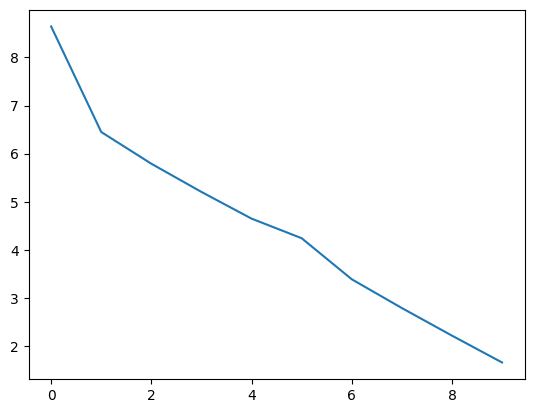

In [59]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(train_loss)), train_loss)

In [62]:
for input_batch, target_batch in val_dataloader:
    model.eval()
    with torch.no_grad():
        input_batch = input_batch.to(device)
        logits = model(input_batch)
        loss = calc_loss_batch(model, device, input_batch, target_batch)
        print(loss) 

tensor(7.3264, device='cuda:0')
tensor(6.3399, device='cuda:0')


In [67]:
model.pos_emb.weight.shape, GPT_CONFIG_124M

(torch.Size([256, 768]),
 {'vocab_size': 50257,
  'context_length': 256,
  'emb_dim': 768,
  'n_heads': 12,
  'n_layers': 2,
  'drop_rate': 0.1,
  'qkv_bias': False})

In [115]:
# From Book:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen



# LLM Training:=>
# torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 1 #10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.635, Val loss 10.845
Ep 1 (Step 000005): Train loss 8.245, Val loss 9.136
Every effort moves you, the,, the the, the,,, the, the,,,,,,,,,,,, the,, the,,,,, the,,, the,,, the the,,,,,


In [114]:
model = GPTModel(GPT_CONFIG_124M)
for x, y in train_dataloader:
    print(x.shape)
    print(y.shape)
    logits = model(x)
    print(logits.shape)

    print('------')
    print(logits[0].shape)
    print(y[0].shape)
    loss = torch.nn.functional.cross_entropy(logits[0], y[0]) #logits.flatten(0, 1), y.flatten())
    print(y[0][:10])
    print(loss)
    # print(logits[0].shape)

    break
    # loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), y.flatten())

torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 256, 50257])
------
torch.Size([256, 50257])
torch.Size([256])
tensor([  367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138,   257])
tensor(10.9990, grad_fn=<NllLossBackward0>)


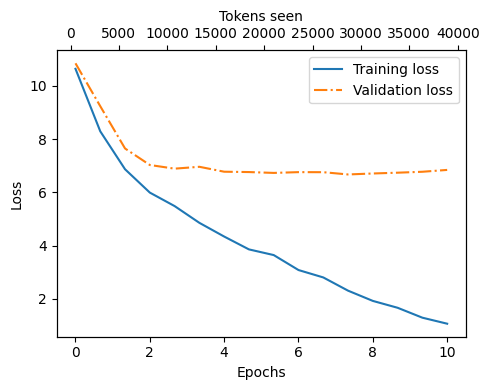

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 4))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [80]:
GPT_CONFIG_124M['context_length']

256

In [ ]:
txt = 'hello this is a gr8 life'
encodings = text_to_token_ids(txt, tokenizer)
logits = model(encodings)

tensor([[31373,   428,   318,   257,  1036,    23,  1204]])